# Machine Learning Practical: Coursework 1

**Release date: Monday 10th October 2016**  
**Due date: 16:00 Thursday 27th October 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_1.pdf).

## Part 1: Learning rate schedules

In [1]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [2]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()

* Compare the performance of your time-dependent learning rate schedule when training the standard model on the MNIST digit classiﬁcation task, to training with a constant learning rate baseline.*

In [3]:
def train_model_with_time_dependent_lr(
        free_parameter, model, error, learning_rule, train_data, 
        valid_data, num_epochs, stats_interval):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    input_dim, output_dim, hidden_dim = 784, 10, 100

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
# Use the created objects to initialise a new Optimiser instance.
    schedulers = [TimeDependentLearningRateScheduler(learning_rate,free_parameter)]
    optimiser = Optimiser(
        model, error, learning_rule, train_data,
        valid_data, data_monitors,schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    return stats,keys,run_time

def train_model_with_constant_lr(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    input_dim, output_dim, hidden_dim = 784, 10, 100

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use the created objects to initialise a new Optimiser instance.
    schedulers = [ConstantLearningRateScheduler(learning_rate)]
    optimiser = Optimiser(
        model, error, learning_rule, train_data,
        valid_data, data_monitors,schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    return stats, keys, run_time
    
def plot_both(stats1,stats2,keys1,run_time1,run_time2):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                  stats1[1:, keys1[k]], label= 'time-dependent LR:'+ k)
        ax_1.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                   stats2[1:, keys1[k]], label='constant LR:' + k, linestyle='-.')
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.savefig('error_train_valid.pdf')
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                  stats1[1:, keys1[k]], label= 'time-dependent LR:'+ k)
        ax_2.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                   stats2[1:, keys1[k]], label='constant LR:' + k, linestyle='-.')
                  
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.savefig('acc_train_valid.pdf')
   
    return stats1,stats2,keys1, keys2, run_time1,run_time2, fig_1, ax_1, fig_2, ax_2

Epoch 5: 1.20s to complete
    error(train)=2.74e-01, acc(train)=9.21e-01, error(valid)=2.57e-01, acc(valid)=9.25e-01
Epoch 10: 1.18s to complete
    error(train)=2.16e-01, acc(train)=9.37e-01, error(valid)=2.07e-01, acc(valid)=9.41e-01
Epoch 15: 1.16s to complete
    error(train)=1.92e-01, acc(train)=9.44e-01, error(valid)=1.86e-01, acc(valid)=9.48e-01
Epoch 20: 1.23s to complete
    error(train)=1.78e-01, acc(train)=9.49e-01, error(valid)=1.75e-01, acc(valid)=9.51e-01
Epoch 25: 1.21s to complete
    error(train)=1.72e-01, acc(train)=9.51e-01, error(valid)=1.69e-01, acc(valid)=9.54e-01
Epoch 30: 1.30s to complete
    error(train)=1.67e-01, acc(train)=9.52e-01, error(valid)=1.66e-01, acc(valid)=9.54e-01
Epoch 35: 1.26s to complete
    error(train)=1.65e-01, acc(train)=9.53e-01, error(valid)=1.64e-01, acc(valid)=9.54e-01
Epoch 40: 1.27s to complete
    error(train)=1.64e-01, acc(train)=9.53e-01, error(valid)=1.63e-01, acc(valid)=9.55e-01
Epoch 45: 1.42s to complete
    error(train)=1.63

[[ 2.57014219  0.09718     2.57424905  0.0983    ]
 [ 0.27355156  0.92134     0.25732261  0.9252    ]
 [ 0.21645197  0.93712     0.20730446  0.9415    ]
 [ 0.19184727  0.94424     0.18611772  0.9485    ]
 [ 0.17839803  0.94858     0.17515661  0.9514    ]
 [ 0.17170058  0.95052     0.16942449  0.9539    ]
 [ 0.16738707  0.95168     0.16614062  0.954     ]
 [ 0.16496252  0.95268     0.16423445  0.9541    ]
 [ 0.16354038  0.95302     0.16309726  0.9548    ]
 [ 0.16267999  0.95342     0.16242768  0.9552    ]
 [ 0.16216835  0.95364     0.16204901  0.9552    ]
 [ 0.1618616   0.95364     0.16180867  0.9553    ]
 [ 0.16167547  0.95372     0.16166206  0.9554    ]
 [ 0.16156307  0.95368     0.16157266  0.9554    ]
 [ 0.161495    0.9537      0.16151881  0.9554    ]
 [ 0.16145373  0.95372     0.16148663  0.9554    ]
 [ 0.1614287   0.95372     0.16146731  0.9554    ]
 [ 0.16141353  0.95372     0.16145558  0.9554    ]
 [ 0.16140433  0.95374     0.16144842  0.9554    ]
 [ 0.16139875  0.95374     0.16

Epoch 5: 1.28s to complete
    error(train)=2.58e-01, acc(train)=9.25e-01, error(valid)=2.43e-01, acc(valid)=9.30e-01
Epoch 10: 1.22s to complete
    error(train)=1.70e-01, acc(train)=9.51e-01, error(valid)=1.66e-01, acc(valid)=9.56e-01
Epoch 15: 1.22s to complete
    error(train)=1.24e-01, acc(train)=9.64e-01, error(valid)=1.33e-01, acc(valid)=9.63e-01
Epoch 20: 1.20s to complete
    error(train)=9.45e-02, acc(train)=9.73e-01, error(valid)=1.13e-01, acc(valid)=9.67e-01
Epoch 25: 1.25s to complete
    error(train)=7.71e-02, acc(train)=9.78e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01
Epoch 30: 1.20s to complete
    error(train)=5.93e-02, acc(train)=9.84e-01, error(valid)=9.35e-02, acc(valid)=9.73e-01
Epoch 35: 1.26s to complete
    error(train)=4.74e-02, acc(train)=9.88e-01, error(valid)=8.90e-02, acc(valid)=9.74e-01
Epoch 40: 1.27s to complete
    error(train)=3.95e-02, acc(train)=9.90e-01, error(valid)=8.69e-02, acc(valid)=9.75e-01
Epoch 45: 1.23s to complete
    error(train)=3.16

[[ 2.42502346  0.09902     2.42933527  0.0967    ]
 [ 0.25801619  0.9245      0.24251385  0.9305    ]
 [ 0.16990599  0.9511      0.16607295  0.956     ]
 [ 0.12352473  0.96404     0.13296311  0.9635    ]
 [ 0.09447317  0.9728      0.1134376   0.9673    ]
 [ 0.07712001  0.97826     0.10451566  0.9693    ]
 [ 0.05927006  0.98426     0.09345531  0.973     ]
 [ 0.04736337  0.9881      0.08897223  0.9739    ]
 [ 0.03948855  0.9902      0.08690678  0.9746    ]
 [ 0.03158442  0.99318     0.08122375  0.9762    ]
 [ 0.02681624  0.99428     0.08003866  0.9752    ]
 [ 0.02186948  0.99584     0.0791149   0.9778    ]
 [ 0.01773002  0.99752     0.07878024  0.9778    ]
 [ 0.01635283  0.99784     0.08058536  0.9768    ]
 [ 0.01287361  0.9984      0.0795937   0.9778    ]
 [ 0.01055467  0.99902     0.0798446   0.9774    ]
 [ 0.00912377  0.99936     0.08130315  0.9772    ]
 [ 0.00780704  0.9995      0.08287927  0.9776    ]
 [ 0.00670443  0.99978     0.08241646  0.9779    ]
 [ 0.00586074  0.99984     0.08

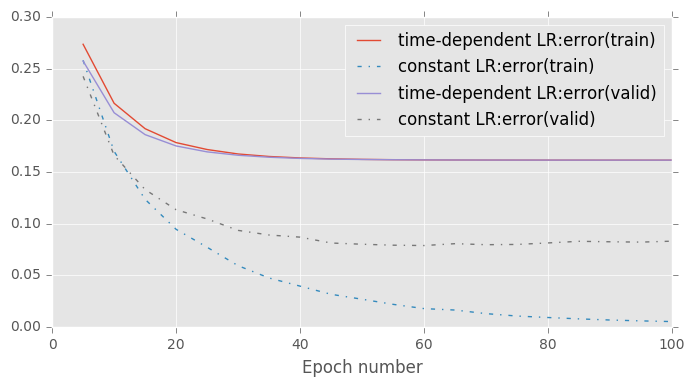

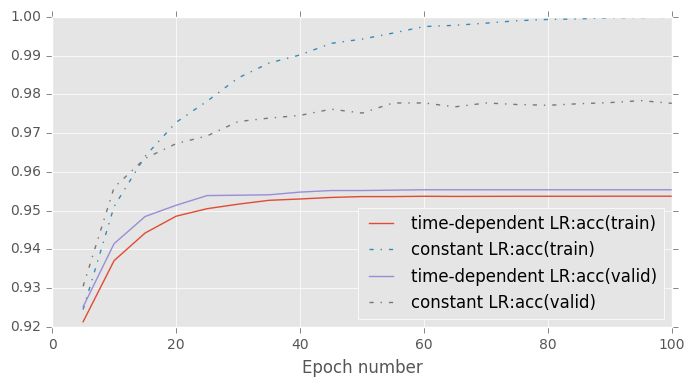

In [5]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # initial learning rate for gradient descent
num_epochs = 100 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = 10 # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results




learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

rng.seed(seed)
train_data.reset()
valid_data.reset()
    
stats1, keys1, run_time1 = train_model_with_time_dependent_lr(
    free_parameter, model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)

stats2, keys2, run_time2 = train_model_with_constant_lr(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

_ = plot_both(stats1,stats2,keys1,run_time1,run_time2)

*Answer:* When the initial learning rate of the time-dependent learning rate is 0.1 and the free parameter is set to 10. We found that the performance in the validation set is better than that in the training set, whereas the performance in the validation set is worse for the constant learning rate. Howeverm the overall performance of the time-dependent learning rate set is worse than it in the constant set.

*Indicate how the free schedule parameters η0 and r affect the evolution of the training.*

1


Epoch 5: 0.95s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 10: 0.96s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 15: 1.01s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 20: 0.97s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 25: 1.00s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 30: 1.01s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 35: 0.99s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 40: 1.01s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 45: 0.93s to complete
    error(train)=5.74

2


Epoch 5: 0.95s to complete
    error(train)=4.06e-01, acc(train)=8.89e-01, error(valid)=3.76e-01, acc(valid)=8.98e-01
Epoch 10: 1.19s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 15: 1.06s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 20: 1.02s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 25: 1.06s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 30: 1.03s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 35: 0.95s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 40: 0.94s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 45: 0.94s to complete
    error(train)=4.05

3


Epoch 5: 0.93s to complete
    error(train)=2.78e-01, acc(train)=9.19e-01, error(valid)=2.60e-01, acc(valid)=9.24e-01
Epoch 10: 1.03s to complete
    error(train)=2.19e-01, acc(train)=9.36e-01, error(valid)=2.09e-01, acc(valid)=9.41e-01
Epoch 15: 0.98s to complete
    error(train)=1.92e-01, acc(train)=9.44e-01, error(valid)=1.87e-01, acc(valid)=9.49e-01
Epoch 20: 0.92s to complete
    error(train)=1.79e-01, acc(train)=9.48e-01, error(valid)=1.76e-01, acc(valid)=9.52e-01
Epoch 25: 0.94s to complete
    error(train)=1.72e-01, acc(train)=9.50e-01, error(valid)=1.70e-01, acc(valid)=9.54e-01
Epoch 30: 0.92s to complete
    error(train)=1.67e-01, acc(train)=9.51e-01, error(valid)=1.67e-01, acc(valid)=9.55e-01
Epoch 35: 0.92s to complete
    error(train)=1.65e-01, acc(train)=9.52e-01, error(valid)=1.64e-01, acc(valid)=9.56e-01
Epoch 40: 0.94s to complete
    error(train)=1.63e-01, acc(train)=9.53e-01, error(valid)=1.63e-01, acc(valid)=9.56e-01
Epoch 45: 0.95s to complete
    error(train)=1.62

4


Epoch 5: 1.00s to complete
    error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.45e-01, acc(valid)=9.29e-01
Epoch 10: 1.05s to complete
    error(train)=1.80e-01, acc(train)=9.47e-01, error(valid)=1.77e-01, acc(valid)=9.51e-01
Epoch 15: 0.97s to complete
    error(train)=1.32e-01, acc(train)=9.61e-01, error(valid)=1.39e-01, acc(valid)=9.62e-01
Epoch 20: 0.99s to complete
    error(train)=1.05e-01, acc(train)=9.69e-01, error(valid)=1.22e-01, acc(valid)=9.67e-01
Epoch 25: 0.97s to complete
    error(train)=8.65e-02, acc(train)=9.75e-01, error(valid)=1.10e-01, acc(valid)=9.70e-01
Epoch 30: 1.02s to complete
    error(train)=7.63e-02, acc(train)=9.78e-01, error(valid)=1.07e-01, acc(valid)=9.71e-01
Epoch 35: 0.97s to complete
    error(train)=6.09e-02, acc(train)=9.84e-01, error(valid)=9.77e-02, acc(valid)=9.72e-01
Epoch 40: 0.96s to complete
    error(train)=5.15e-02, acc(train)=9.87e-01, error(valid)=9.22e-02, acc(valid)=9.75e-01
Epoch 45: 1.03s to complete
    error(train)=4.54

5


Epoch 5: 0.92s to complete
    error(train)=2.60e-01, acc(train)=9.25e-01, error(valid)=2.43e-01, acc(valid)=9.28e-01
Epoch 10: 0.92s to complete
    error(train)=1.74e-01, acc(train)=9.49e-01, error(valid)=1.69e-01, acc(valid)=9.54e-01
Epoch 15: 0.92s to complete
    error(train)=1.27e-01, acc(train)=9.63e-01, error(valid)=1.34e-01, acc(valid)=9.63e-01
Epoch 20: 0.92s to complete
    error(train)=9.68e-02, acc(train)=9.72e-01, error(valid)=1.15e-01, acc(valid)=9.67e-01
Epoch 25: 0.95s to complete
    error(train)=7.79e-02, acc(train)=9.78e-01, error(valid)=1.03e-01, acc(valid)=9.71e-01
Epoch 30: 0.96s to complete
    error(train)=6.41e-02, acc(train)=9.82e-01, error(valid)=9.66e-02, acc(valid)=9.72e-01
Epoch 35: 0.92s to complete
    error(train)=5.23e-02, acc(train)=9.86e-01, error(valid)=9.16e-02, acc(valid)=9.73e-01
Epoch 40: 0.92s to complete
    error(train)=4.21e-02, acc(train)=9.89e-01, error(valid)=8.53e-02, acc(valid)=9.75e-01
Epoch 45: 0.92s to complete
    error(train)=3.45

6


Epoch 5: 0.91s to complete
    error(train)=2.55e-01, acc(train)=9.27e-01, error(valid)=2.40e-01, acc(valid)=9.31e-01
Epoch 10: 0.92s to complete
    error(train)=1.73e-01, acc(train)=9.50e-01, error(valid)=1.70e-01, acc(valid)=9.54e-01
Epoch 15: 0.92s to complete
    error(train)=1.29e-01, acc(train)=9.63e-01, error(valid)=1.37e-01, acc(valid)=9.62e-01
Epoch 20: 0.93s to complete
    error(train)=9.64e-02, acc(train)=9.72e-01, error(valid)=1.15e-01, acc(valid)=9.69e-01
Epoch 25: 0.93s to complete
    error(train)=7.51e-02, acc(train)=9.79e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01
Epoch 30: 0.93s to complete
    error(train)=6.05e-02, acc(train)=9.84e-01, error(valid)=9.46e-02, acc(valid)=9.74e-01
Epoch 35: 0.92s to complete
    error(train)=5.23e-02, acc(train)=9.86e-01, error(valid)=9.36e-02, acc(valid)=9.74e-01
Epoch 40: 0.94s to complete
    error(train)=4.03e-02, acc(train)=9.90e-01, error(valid)=8.71e-02, acc(valid)=9.74e-01
Epoch 45: 0.92s to complete
    error(train)=3.42

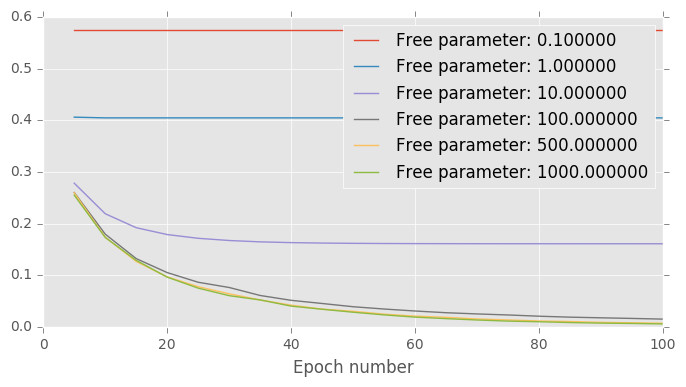

In [25]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # initial learning rate for gradient descent
num_epochs = 100 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = np.array([0.1,1.,10.,100.,500.,1000.])  # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

rng.seed(seed)
train_data.reset()
valid_data.reset()

# for  in free_parameter:
#     stats = np.zeros(np.size(free_parameter))
#     stats[i], keys, run_time[i] = train_model_with_time_dependent_lr(
#     k, model, error, learning_rule, train_data, 
#     valid_data, num_epochs, stats_interval)
#     i=i+1
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for i in np.arange(1,np.size(free_parameter)+1):
    print i
    stats, keys, run_time = train_model_with_time_dependent_lr(
    free_parameter[i-1], model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)
    k ='error(train)'
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label= 'Free parameter: ' + '%f' %free_parameter[i-1])
#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])      
#     for k in ['error(train)', 'error(valid)']:
#         ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])  

    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
fig_1.savefig("error_in_train_free_parameter.pdf")


1
0.01


Epoch 5: 0.94s to complete
    error(train)=1.19e+00, acc(train)=7.09e-01, error(valid)=1.17e+00, acc(valid)=7.37e-01
Epoch 10: 1.02s to complete
    error(train)=7.83e-01, acc(train)=7.99e-01, error(valid)=7.47e-01, acc(valid)=8.22e-01
Epoch 15: 0.98s to complete
    error(train)=6.60e-01, acc(train)=8.25e-01, error(valid)=6.23e-01, acc(valid)=8.42e-01
Epoch 20: 0.98s to complete
    error(train)=6.07e-01, acc(train)=8.37e-01, error(valid)=5.70e-01, acc(valid)=8.53e-01
Epoch 25: 0.96s to complete
    error(train)=5.79e-01, acc(train)=8.45e-01, error(valid)=5.43e-01, acc(valid)=8.60e-01
Epoch 30: 1.12s to complete
    error(train)=5.64e-01, acc(train)=8.49e-01, error(valid)=5.29e-01, acc(valid)=8.63e-01
Epoch 35: 0.99s to complete
    error(train)=5.56e-01, acc(train)=8.51e-01, error(valid)=5.21e-01, acc(valid)=8.65e-01
Epoch 40: 1.03s to complete
    error(train)=5.51e-01, acc(train)=8.52e-01, error(valid)=5.16e-01, acc(valid)=8.66e-01
Epoch 45: 1.10s to complete
    error(train)=5.48

2
0.1


Epoch 5: 1.26s to complete
    error(train)=2.77e-01, acc(train)=9.19e-01, error(valid)=2.59e-01, acc(valid)=9.26e-01
Epoch 10: 1.09s to complete
    error(train)=2.17e-01, acc(train)=9.37e-01, error(valid)=2.06e-01, acc(valid)=9.42e-01
Epoch 15: 1.00s to complete
    error(train)=1.91e-01, acc(train)=9.44e-01, error(valid)=1.85e-01, acc(valid)=9.48e-01
Epoch 20: 0.96s to complete
    error(train)=1.78e-01, acc(train)=9.48e-01, error(valid)=1.75e-01, acc(valid)=9.52e-01
Epoch 25: 0.93s to complete
    error(train)=1.71e-01, acc(train)=9.49e-01, error(valid)=1.68e-01, acc(valid)=9.54e-01
Epoch 30: 0.99s to complete
    error(train)=1.66e-01, acc(train)=9.51e-01, error(valid)=1.65e-01, acc(valid)=9.55e-01
Epoch 35: 0.94s to complete
    error(train)=1.64e-01, acc(train)=9.52e-01, error(valid)=1.63e-01, acc(valid)=9.56e-01
Epoch 40: 0.94s to complete
    error(train)=1.62e-01, acc(train)=9.52e-01, error(valid)=1.62e-01, acc(valid)=9.56e-01
Epoch 45: 0.93s to complete
    error(train)=1.61

3
1.0


Epoch 5: 0.96s to complete
    error(train)=6.47e-02, acc(train)=9.81e-01, error(valid)=9.42e-02, acc(valid)=9.72e-01
Epoch 10: 1.10s to complete
    error(train)=2.85e-02, acc(train)=9.93e-01, error(valid)=7.77e-02, acc(valid)=9.77e-01
Epoch 15: 1.10s to complete
    error(train)=1.74e-02, acc(train)=9.97e-01, error(valid)=7.58e-02, acc(valid)=9.78e-01
Epoch 20: 1.18s to complete
    error(train)=1.32e-02, acc(train)=9.98e-01, error(valid)=7.68e-02, acc(valid)=9.79e-01
Epoch 25: 1.05s to complete
    error(train)=1.11e-02, acc(train)=9.99e-01, error(valid)=7.66e-02, acc(valid)=9.79e-01
Epoch 30: 0.97s to complete
    error(train)=9.93e-03, acc(train)=9.99e-01, error(valid)=7.71e-02, acc(valid)=9.79e-01
Epoch 35: 0.99s to complete
    error(train)=9.40e-03, acc(train)=9.99e-01, error(valid)=7.69e-02, acc(valid)=9.78e-01
Epoch 40: 0.94s to complete
    error(train)=9.10e-03, acc(train)=9.99e-01, error(valid)=7.70e-02, acc(valid)=9.79e-01
Epoch 45: 0.95s to complete
    error(train)=8.93

4
10


Epoch 5: 0.93s to complete
    error(train)=2.55e+00, acc(train)=9.68e-02, error(valid)=2.54e+00, acc(valid)=1.01e-01
Epoch 10: 0.93s to complete
    error(train)=2.35e+00, acc(train)=9.68e-02, error(valid)=2.35e+00, acc(valid)=1.01e-01
Epoch 15: 0.93s to complete
    error(train)=2.33e+00, acc(train)=9.94e-02, error(valid)=2.33e+00, acc(valid)=9.90e-02
Epoch 20: 0.92s to complete
    error(train)=2.32e+00, acc(train)=9.94e-02, error(valid)=2.32e+00, acc(valid)=9.90e-02
Epoch 25: 0.92s to complete
    error(train)=1.68e+00, acc(train)=2.01e-01, error(valid)=1.68e+00, acc(valid)=2.03e-01
Epoch 30: 0.97s to complete
    error(train)=1.21e+00, acc(train)=5.07e-01, error(valid)=1.22e+00, acc(valid)=5.01e-01
Epoch 35: 0.93s to complete
    error(train)=3.14e-01, acc(train)=9.23e-01, error(valid)=3.43e-01, acc(valid)=9.16e-01
Epoch 40: 0.98s to complete
    error(train)=2.17e-01, acc(train)=9.51e-01, error(valid)=2.72e-01, acc(valid)=9.37e-01
Epoch 45: 1.07s to complete
    error(train)=1.70

5
100


Epoch 5: 0.93s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 10: 0.91s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 15: 0.87s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 20: 0.91s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 25: 0.92s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 30: 1.05s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 35: 0.89s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 40: 0.90s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 45: 1.02s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 50: 1.04s to c

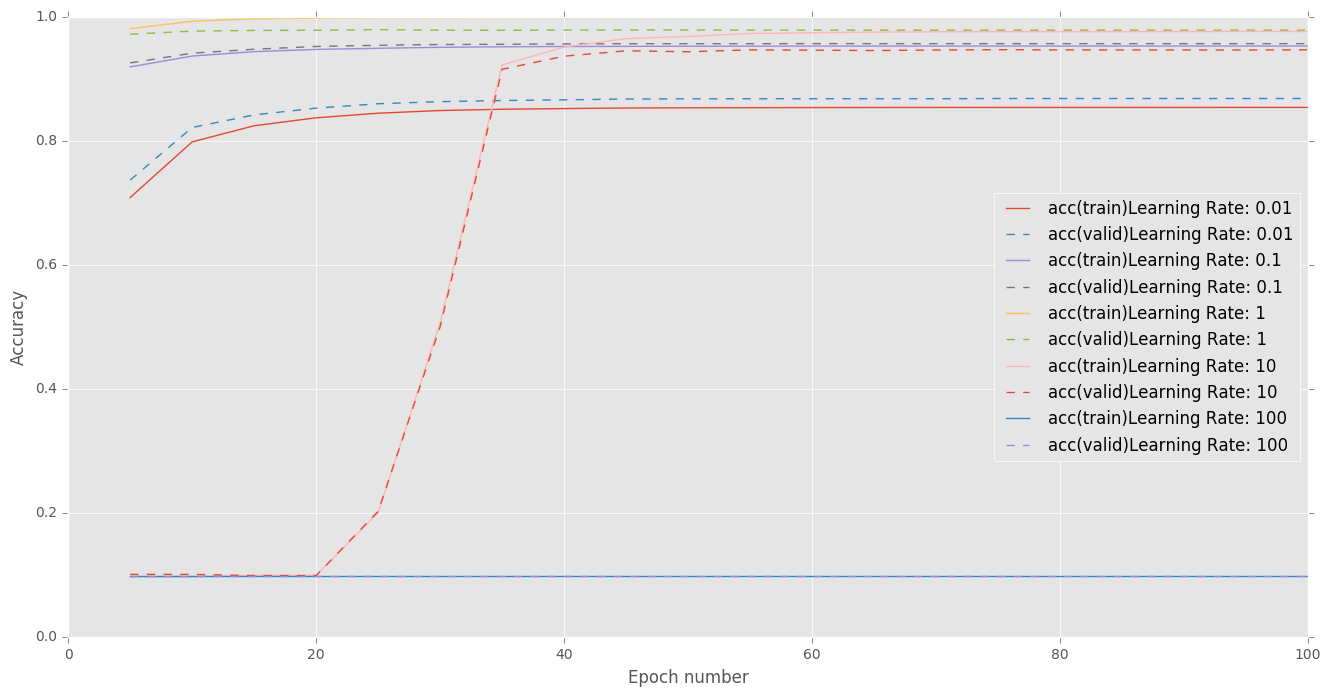

In [37]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation

lr = [0.01,0.1,1.0,10,100]  # initial learning rate for gradient descent

num_epochs = 100 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = 10  # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results


rng.seed(seed)
train_data.reset()
valid_data.reset()

# for  in free_parameter:
#     stats = np.zeros(np.size(free_parameter))
#     stats[i], keys, run_time[i] = train_model_with_time_dependent_lr(
#     k, model, error, learning_rule, train_data, 
#     valid_data, num_epochs, stats_interval)
#     i=i+1
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(16, 8))
ax_1 = fig_1.add_subplot(111)

for i in np.arange(1,np.size(lr)+1):
    print i
    learning_rate = lr[i-1]
    learning_rule = GradientDescentLearningRule(learning_rate = learning_rate)
    stats, keys, run_time = train_model_with_time_dependent_lr(
    free_parameter, model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)
    for k in ['acc(train)', 'acc(valid)']:
        if k == 'acc(train)':
            ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label= k +'Learning Rate: %g' %learning_rate)
        else:
            ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label= k +'Learning Rate: %g' %learning_rate,linestyle='--')  
            
#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])      
#     for k in ['error(train)', 'error(valid)']:
#         ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])  
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
ax_1.set_ylabel('Accuracy')
fig_1.savefig('LR_comparison.pdf')

## Part 2: Momentum learning rule

In [ ]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [38]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()

*First Task >> Compare the performance of a basic gradient descent learning rule to the momentum learning rule for several values of the momentum coeﬃcient α.*

## Part 3: Adaptive learning rules

In [ ]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [ ]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()